In [122]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from stats import *
import collections
import os
#import tensorflow as tf
from datetime import datetime
import numpy as np
import pandas as pd
import pickle as p
import random
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import DBSCAN,KMeans
#from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import scipy as sp
import pickle
from scipy.stats import itemfreq
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import pandas as pd
import pickle as p
import random
import keras
from keras import backend as K
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords 
from keras.layers import LeakyReLU
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('italian'))
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

In [148]:
data = pd.read_csv('2020_week3_predictions.csv',sep=';',dtype={'cod_mart':str,'cod_mdep':str,'codAgente':str,'codPtoVend':str})


In [149]:
data=data[~data.anno.isna()]

In [150]:
data['anno'] = data['anno'].astype('int')

In [151]:
data=data[(data.qta_venduta>=0) ]

In [152]:
data=data[data.anno>=2017]

In [153]:
df1 = data

In [154]:
df1.columns

Index(['cod_mart', 'cod_mdep', 'anno', 'settimana', 'ricorrenza', 'peso',
       'descr_mgrp', 'descr_msgr', 'descr_msfa', 'qta_cnf', 'gg_scad_partita',
       'promoNoPromo', 'sum_promo', 'QtaMediaVendGiorn',
       'PrezzoMedioVendGiorn', 'week1_ptoVend', 'week2_ptoVend',
       'week3_ptoVend', 'week4_ptoVend', 'week5_ptoVend', 'week6_ptoVend',
       'week7_ptoVend', 'prezzo_vendita', 'min_prezzo_vendita',
       'max_prezzo_vendita', 'variazione_prezzo', 'min_variazione_prezzo',
       'max_variazione_prezzo', 'stdev_variazione_prezzo', 'dev_std_30',
       'media_30', 'media_15', 'media_7', 'QuantitaSostituita', 'inevaso',
       'QuantitaResa', 'ConfRese', 'QuantitaOmaggi', 'qta_venduta'],
      dtype='object')

In [155]:
df1=df1[(df1.descr_mgrp!='PARMALAT') & (df1.cod_mart!='811825')]
#df1=df1[~df1.cod_mart.isin(df1.cod_mart.value_counts()[500:].index)]

In [156]:
clusters=pd.read_csv('C:/Users/Administrator/Desktop/VG_Project/Agloritmi/clusters_week',dtype={'cod_mart':str,'cod_mdep':str})    
#df['cod_mart']=df.cod_mart.where(df.cod_mart.str[:1]!=str(0),df.cod_mart.str[1:])
df1 = pd.merge(df1,clusters,on=['cod_mdep','cod_mart', 'descr_mgrp', 'descr_msgr', 'descr_msfa'],how='left')
df1=df1[~df1.cluster.isna()]

In [157]:
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_sum',['cod_mdep','descr_mgrp','anno','settimana'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_sum',['cod_mdep','descr_msgr','anno','settimana'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_sum',['cod_mdep','descr_msfa','anno','settimana'],'qta_venduta','sum',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_mean',['cod_mdep','descr_mgrp','anno','settimana'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_mean',['cod_mdep','descr_msgr','anno','settimana'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_mean',['cod_mdep','descr_msfa','anno','settimana'],'qta_venduta','mean',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_mgrp_max',['cod_mdep','descr_mgrp','anno','settimana'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msgr_max',['cod_mdep','descr_msgr','anno','settimana'],'qta_venduta','max',1)
df1=shifted_standard_feature(df1,'qta_venduta_prec_msfa_max',['cod_mdep','descr_msfa','anno','settimana'],'qta_venduta','max',1)

In [158]:
df1=rolling_feature(df1,'qta_venduta_prec_anno_mean',['cod_mdep','cod_mart','settimana','anno'],['cod_mdep','cod_mart','settimana'],'qta_venduta','mean',3,1)

In [159]:
df1['anno'] = df1['anno'].astype('int')

In [160]:
unique_dict = np.load('C:/Users/Administrator/Desktop/VG_Project/Agloritmi/dictionaries/unique_dict_week.npy',allow_pickle=True).item()
unique_df=pd.DataFrame.from_dict(unique_dict, orient='index').reset_index()
unique_df.rename(columns={'index':'descr_join'}, inplace=True)
df1['descr_join']=df1['descr_mgrp'].astype(str)+" "+df1['descr_msgr'].astype(str)+" "+df1['descr_msfa'].astype(str)
df1.drop(['descr_mgrp','descr_msgr','descr_msfa'], axis=1, inplace=True)
df1 = df1.merge(unique_df,on=['descr_join'],how='left')

In [161]:
df1.drop('descr_join',axis=1,inplace=True)    

In [162]:
df1=df1[df1.anno>=2018]

In [163]:
df_train = df1.loc[(df1.anno<=2020) |((df1.anno==2021)|(df1.settimana<=10))] 
df_val = df1.loc[(df1['anno']==2020)] 
df_test=df1.loc[df1['anno'] ==2020]

In [164]:
df_val.drop('anno',axis=1, inplace=True)
df_train.drop('anno',axis=1 , inplace=True)
df_test.drop('anno',axis=1 , inplace=True)

In [165]:
X, y =df_train.drop(['cod_mart','qta_venduta'],axis=1),df_train['qta_venduta']
#X_train, X_test,X_val, y_train, y_test,y_val=X,df_test.drop(['qta_venduta'],axis=1),df_val.drop(['cod_mart','qta_venduta'],
 #                                                                                                axis=1),y,df_test['qta_venduta'],df_val['qta_venduta']
X_train,X_val,X_test, y_train,y_val,y_test=X,df_val.drop(['cod_mart','qta_venduta'],axis=1),\
                                            df_test.drop(['cod_mart','qta_venduta'],axis=1),\
                                            y,df_val['qta_venduta'],df_test['qta_venduta']


In [166]:
X_val.drop([ 'QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi','min_variazione_prezzo'],axis=1,inplace=True)
X_train.drop([ 'QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi','min_variazione_prezzo'],axis=1,inplace=True)
X_test.drop([ 'QuantitaSostituita',
       'inevaso', 'QuantitaResa', 'ConfRese', 'QuantitaOmaggi','min_variazione_prezzo'],axis=1,inplace=True)
X_test.fillna(25,inplace=True)
X_train.fillna(25,inplace=True)
X_val.fillna(25,inplace=True)
X_train.cod_mdep=0
X_val.cod_mdep=0

In [167]:
X_train.columns

Index(['cod_mdep', 'settimana', 'ricorrenza', 'peso', 'qta_cnf',
       'gg_scad_partita', 'promoNoPromo', 'sum_promo', 'QtaMediaVendGiorn',
       'PrezzoMedioVendGiorn', 'week1_ptoVend', 'week2_ptoVend',
       'week3_ptoVend', 'week4_ptoVend', 'week5_ptoVend', 'week6_ptoVend',
       'week7_ptoVend', 'prezzo_vendita', 'min_prezzo_vendita',
       'max_prezzo_vendita', 'variazione_prezzo', 'max_variazione_prezzo',
       'stdev_variazione_prezzo', 'dev_std_30', 'media_30', 'media_15',
       'media_7', 'cluster', 'qta_venduta_prec_mgrp_sum',
       'qta_venduta_prec_msgr_sum', 'qta_venduta_prec_msfa_sum',
       'qta_venduta_prec_mgrp_mean', 'qta_venduta_prec_msgr_mean',
       'qta_venduta_prec_msfa_mean', 'qta_venduta_prec_mgrp_max',
       'qta_venduta_prec_msgr_max', 'qta_venduta_prec_msfa_max',
       'qta_venduta_prec_anno_mean', 'descr_mgrp', 'descr_msgr', 'descr_msfa',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [168]:
from catboost import CatBoostRegressor
X_train.cluster=X_train.cluster.astype('int32')
X_val.cluster=X_val.cluster.astype('int32')
X_train.promoNoPromo=X_train.promoNoPromo.astype('int32')
X_val.promoNoPromo=X_val.promoNoPromo.astype('int32')
X_train.qta_cnf=X_train.qta_cnf.astype('int32')
X_val.qta_cnf=X_val.qta_cnf.astype('int32')
model = CatBoostRegressor(
n_estimators = 2000,#7345#2755
loss_function = 'MAE',
#l2_leaf_reg=1,
#learning_rate=0.05,
#depth=10,
#min_child_samples=1,
eval_metric = 'MAE',
cat_features =[0,1,2,4,5,6,7,27,38,39,40] )#1.7582339

In [169]:
grid = {
        'depth': [6,7,8,9,10]}

In [170]:
6.69

6.69

In [171]:
model.fit(X_train,y_train,eval_set=(X_val,y_val))

0:	learn: 239.9706734	test: 203.4622964	best: 203.4622964 (0)	total: 147ms	remaining: 4m 54s
1:	learn: 237.3056302	test: 201.0630526	best: 201.0630526 (1)	total: 286ms	remaining: 4m 45s
2:	learn: 234.8416089	test: 198.8750161	best: 198.8750161 (2)	total: 410ms	remaining: 4m 32s
3:	learn: 231.7570696	test: 196.0377839	best: 196.0377839 (3)	total: 548ms	remaining: 4m 33s
4:	learn: 229.2039908	test: 193.7005030	best: 193.7005030 (4)	total: 697ms	remaining: 4m 38s
5:	learn: 226.9701469	test: 191.6672692	best: 191.6672692 (5)	total: 836ms	remaining: 4m 37s
6:	learn: 223.6171258	test: 188.7671701	best: 188.7671701 (6)	total: 982ms	remaining: 4m 39s
7:	learn: 221.1792092	test: 186.7117054	best: 186.7117054 (7)	total: 1.11s	remaining: 4m 36s
8:	learn: 218.2815908	test: 184.1766112	best: 184.1766112 (8)	total: 1.27s	remaining: 4m 40s
9:	learn: 216.0608337	test: 182.2508922	best: 182.2508922 (9)	total: 1.4s	remaining: 4m 39s
10:	learn: 212.9819766	test: 179.6735800	best: 179.6735800 (10)	total: 

89:	learn: 90.7121936	test: 81.0943832	best: 81.0943832 (89)	total: 11.8s	remaining: 4m 11s
90:	learn: 90.2905134	test: 80.8549095	best: 80.8549095 (90)	total: 12s	remaining: 4m 11s
91:	learn: 89.7551387	test: 80.4800314	best: 80.4800314 (91)	total: 12.1s	remaining: 4m 11s
92:	learn: 89.2216952	test: 80.0654774	best: 80.0654774 (92)	total: 12.2s	remaining: 4m 11s
93:	learn: 88.5836262	test: 79.6206019	best: 79.6206019 (93)	total: 12.4s	remaining: 4m 10s
94:	learn: 88.1838760	test: 79.3117823	best: 79.3117823 (94)	total: 12.5s	remaining: 4m 10s
95:	learn: 87.8798608	test: 79.0622801	best: 79.0622801 (95)	total: 12.6s	remaining: 4m 9s
96:	learn: 87.5018516	test: 78.8063236	best: 78.8063236 (96)	total: 12.7s	remaining: 4m 9s
97:	learn: 86.7617517	test: 78.2772907	best: 78.2772907 (97)	total: 12.8s	remaining: 4m 8s
98:	learn: 86.2248849	test: 77.8654953	best: 77.8654953 (98)	total: 12.9s	remaining: 4m 8s
99:	learn: 85.6759131	test: 77.4745663	best: 77.4745663 (99)	total: 13.1s	remaining: 4

179:	learn: 68.8140518	test: 65.3967204	best: 65.3967204 (179)	total: 23s	remaining: 3m 52s
180:	learn: 68.8115795	test: 65.3941955	best: 65.3941955 (180)	total: 23.1s	remaining: 3m 52s
181:	learn: 68.8016388	test: 65.3868598	best: 65.3868598 (181)	total: 23.2s	remaining: 3m 52s
182:	learn: 68.6835464	test: 65.3076949	best: 65.3076949 (182)	total: 23.4s	remaining: 3m 52s
183:	learn: 68.6803400	test: 65.3042427	best: 65.3042427 (183)	total: 23.5s	remaining: 3m 52s
184:	learn: 68.6639092	test: 65.2787862	best: 65.2787862 (184)	total: 23.7s	remaining: 3m 52s
185:	learn: 68.5962912	test: 65.2407870	best: 65.2407870 (185)	total: 23.8s	remaining: 3m 51s
186:	learn: 68.5800190	test: 65.2230240	best: 65.2230240 (186)	total: 23.9s	remaining: 3m 52s
187:	learn: 68.5193737	test: 65.1698846	best: 65.1698846 (187)	total: 24s	remaining: 3m 51s
188:	learn: 68.4508315	test: 65.1345076	best: 65.1345076 (188)	total: 24.2s	remaining: 3m 51s
189:	learn: 68.4272691	test: 65.1121987	best: 65.1121987 (189)	t

267:	learn: 65.9578649	test: 63.0320032	best: 63.0320032 (267)	total: 34.9s	remaining: 3m 45s
268:	learn: 65.9485261	test: 63.0210808	best: 63.0210808 (268)	total: 35.1s	remaining: 3m 45s
269:	learn: 65.9482305	test: 63.0210367	best: 63.0210367 (269)	total: 35.2s	remaining: 3m 45s
270:	learn: 65.8900023	test: 62.9637004	best: 62.9637004 (270)	total: 35.4s	remaining: 3m 45s
271:	learn: 65.8630482	test: 62.9529611	best: 62.9529611 (271)	total: 35.5s	remaining: 3m 45s
272:	learn: 65.8269239	test: 62.9077938	best: 62.9077938 (272)	total: 35.6s	remaining: 3m 45s
273:	learn: 65.8123947	test: 62.8965364	best: 62.8965364 (273)	total: 35.7s	remaining: 3m 44s
274:	learn: 65.7627272	test: 62.8623471	best: 62.8623471 (274)	total: 35.9s	remaining: 3m 44s
275:	learn: 65.7619917	test: 62.8614615	best: 62.8614615 (275)	total: 36s	remaining: 3m 44s
276:	learn: 65.7608164	test: 62.8594406	best: 62.8594406 (276)	total: 36.1s	remaining: 3m 44s
277:	learn: 65.7414830	test: 62.8391830	best: 62.8391830 (277)

355:	learn: 64.4808203	test: 61.5747336	best: 61.5747336 (355)	total: 46.8s	remaining: 3m 36s
356:	learn: 64.4804412	test: 61.5743769	best: 61.5743769 (356)	total: 46.9s	remaining: 3m 35s
357:	learn: 64.4688376	test: 61.5674540	best: 61.5674540 (357)	total: 47s	remaining: 3m 35s
358:	learn: 64.4667876	test: 61.5660688	best: 61.5660688 (358)	total: 47.2s	remaining: 3m 35s
359:	learn: 64.4324818	test: 61.5478186	best: 61.5478186 (359)	total: 47.3s	remaining: 3m 35s
360:	learn: 64.4321391	test: 61.5473952	best: 61.5473952 (360)	total: 47.4s	remaining: 3m 35s
361:	learn: 64.3854539	test: 61.5210208	best: 61.5210208 (361)	total: 47.6s	remaining: 3m 35s
362:	learn: 64.3608305	test: 61.5048651	best: 61.5048651 (362)	total: 47.7s	remaining: 3m 35s
363:	learn: 64.3344956	test: 61.4462698	best: 61.4462698 (363)	total: 47.8s	remaining: 3m 35s
364:	learn: 64.2940905	test: 61.4223158	best: 61.4223158 (364)	total: 48s	remaining: 3m 34s
365:	learn: 64.2814618	test: 61.3828706	best: 61.3828706 (365)	t

443:	learn: 63.0049658	test: 59.8934269	best: 59.8934269 (443)	total: 58.3s	remaining: 3m 24s
444:	learn: 62.9682047	test: 59.8787873	best: 59.8787873 (444)	total: 58.5s	remaining: 3m 24s
445:	learn: 62.9588045	test: 59.8708787	best: 59.8708787 (445)	total: 58.6s	remaining: 3m 24s
446:	learn: 62.9538844	test: 59.8556304	best: 59.8556304 (446)	total: 58.7s	remaining: 3m 24s
447:	learn: 62.9409570	test: 59.8454280	best: 59.8454280 (447)	total: 58.9s	remaining: 3m 23s
448:	learn: 62.9194234	test: 59.8164471	best: 59.8164471 (448)	total: 59s	remaining: 3m 23s
449:	learn: 62.9157889	test: 59.8134017	best: 59.8134017 (449)	total: 59.1s	remaining: 3m 23s
450:	learn: 62.9067678	test: 59.8032794	best: 59.8032794 (450)	total: 59.2s	remaining: 3m 23s
451:	learn: 62.8612473	test: 59.7728349	best: 59.7728349 (451)	total: 59.4s	remaining: 3m 23s
452:	learn: 62.8443429	test: 59.7511367	best: 59.7511367 (452)	total: 59.5s	remaining: 3m 23s
453:	learn: 62.8360324	test: 59.7414191	best: 59.7414191 (453)

531:	learn: 61.7312222	test: 58.6203264	best: 58.6203264 (531)	total: 1m 10s	remaining: 3m 14s
532:	learn: 61.6907754	test: 58.6021717	best: 58.6021717 (532)	total: 1m 10s	remaining: 3m 14s
533:	learn: 61.6851414	test: 58.5950810	best: 58.5950810 (533)	total: 1m 10s	remaining: 3m 14s
534:	learn: 61.6716898	test: 58.5738281	best: 58.5738281 (534)	total: 1m 10s	remaining: 3m 14s
535:	learn: 61.6630426	test: 58.5682983	best: 58.5682983 (535)	total: 1m 11s	remaining: 3m 14s
536:	learn: 61.6621218	test: 58.5663519	best: 58.5663519 (536)	total: 1m 11s	remaining: 3m 13s
537:	learn: 61.6442794	test: 58.5382124	best: 58.5382124 (537)	total: 1m 11s	remaining: 3m 13s
538:	learn: 61.6255010	test: 58.5107979	best: 58.5107979 (538)	total: 1m 11s	remaining: 3m 13s
539:	learn: 61.6090947	test: 58.4878621	best: 58.4878621 (539)	total: 1m 11s	remaining: 3m 13s
540:	learn: 61.6081031	test: 58.4869936	best: 58.4869936 (540)	total: 1m 11s	remaining: 3m 13s
541:	learn: 61.6065376	test: 58.4856715	best: 58.4

619:	learn: 60.7635567	test: 57.4395694	best: 57.4395694 (619)	total: 1m 22s	remaining: 3m 2s
620:	learn: 60.7517707	test: 57.4296994	best: 57.4296994 (620)	total: 1m 22s	remaining: 3m 2s
621:	learn: 60.7511412	test: 57.4291259	best: 57.4291259 (621)	total: 1m 22s	remaining: 3m 2s
622:	learn: 60.7321770	test: 57.4075632	best: 57.4075632 (622)	total: 1m 22s	remaining: 3m 2s
623:	learn: 60.7295866	test: 57.4025235	best: 57.4025235 (623)	total: 1m 22s	remaining: 3m 2s
624:	learn: 60.7138377	test: 57.3850916	best: 57.3850916 (624)	total: 1m 22s	remaining: 3m 2s
625:	learn: 60.7027870	test: 57.3557417	best: 57.3557417 (625)	total: 1m 22s	remaining: 3m 1s
626:	learn: 60.6769615	test: 57.3162726	best: 57.3162726 (626)	total: 1m 23s	remaining: 3m 1s
627:	learn: 60.6761416	test: 57.3149687	best: 57.3149687 (627)	total: 1m 23s	remaining: 3m 1s
628:	learn: 60.6322368	test: 57.2555564	best: 57.2555564 (628)	total: 1m 23s	remaining: 3m 1s
629:	learn: 60.6091685	test: 57.2329153	best: 57.2329153 (62

707:	learn: 59.9162919	test: 56.4875114	best: 56.4875114 (707)	total: 1m 33s	remaining: 2m 51s
708:	learn: 59.9040515	test: 56.4720842	best: 56.4720842 (708)	total: 1m 33s	remaining: 2m 50s
709:	learn: 59.9032571	test: 56.4712561	best: 56.4712561 (709)	total: 1m 34s	remaining: 2m 50s
710:	learn: 59.9029285	test: 56.4709339	best: 56.4709339 (710)	total: 1m 34s	remaining: 2m 50s
711:	learn: 59.8916839	test: 56.4589332	best: 56.4589332 (711)	total: 1m 34s	remaining: 2m 50s
712:	learn: 59.8915736	test: 56.4589695	best: 56.4589332 (711)	total: 1m 34s	remaining: 2m 50s
713:	learn: 59.8816183	test: 56.4557851	best: 56.4557851 (713)	total: 1m 34s	remaining: 2m 50s
714:	learn: 59.8743439	test: 56.4479139	best: 56.4479139 (714)	total: 1m 34s	remaining: 2m 50s
715:	learn: 59.8724403	test: 56.4468995	best: 56.4468995 (715)	total: 1m 34s	remaining: 2m 50s
716:	learn: 59.8714310	test: 56.4456115	best: 56.4456115 (716)	total: 1m 34s	remaining: 2m 49s
717:	learn: 59.8361040	test: 56.4174647	best: 56.4

795:	learn: 59.2336233	test: 55.7593743	best: 55.7593743 (795)	total: 1m 45s	remaining: 2m 39s
796:	learn: 59.2235369	test: 55.7348106	best: 55.7348106 (796)	total: 1m 45s	remaining: 2m 39s
797:	learn: 59.2205024	test: 55.7318215	best: 55.7318215 (797)	total: 1m 45s	remaining: 2m 38s
798:	learn: 59.2043316	test: 55.7067784	best: 55.7067784 (798)	total: 1m 45s	remaining: 2m 38s
799:	learn: 59.1984438	test: 55.6942417	best: 55.6942417 (799)	total: 1m 45s	remaining: 2m 38s
800:	learn: 59.1980114	test: 55.6939371	best: 55.6939371 (800)	total: 1m 45s	remaining: 2m 38s
801:	learn: 59.1977774	test: 55.6937790	best: 55.6937790 (801)	total: 1m 45s	remaining: 2m 38s
802:	learn: 59.1974365	test: 55.6933705	best: 55.6933705 (802)	total: 1m 46s	remaining: 2m 38s
803:	learn: 59.1870117	test: 55.6877874	best: 55.6877874 (803)	total: 1m 46s	remaining: 2m 38s
804:	learn: 59.1865408	test: 55.6869440	best: 55.6869440 (804)	total: 1m 46s	remaining: 2m 37s
805:	learn: 59.1793786	test: 55.6689849	best: 55.6

883:	learn: 58.3572372	test: 54.8382877	best: 54.8382877 (883)	total: 1m 56s	remaining: 2m 27s
884:	learn: 58.3522288	test: 54.8333340	best: 54.8333340 (884)	total: 1m 56s	remaining: 2m 27s
885:	learn: 58.3519007	test: 54.8329934	best: 54.8329934 (885)	total: 1m 57s	remaining: 2m 27s
886:	learn: 58.3498536	test: 54.8291672	best: 54.8291672 (886)	total: 1m 57s	remaining: 2m 27s
887:	learn: 58.3402328	test: 54.8176006	best: 54.8176006 (887)	total: 1m 57s	remaining: 2m 26s
888:	learn: 58.3373442	test: 54.8122056	best: 54.8122056 (888)	total: 1m 57s	remaining: 2m 26s
889:	learn: 58.3236536	test: 54.7955396	best: 54.7955396 (889)	total: 1m 57s	remaining: 2m 26s
890:	learn: 58.3177663	test: 54.7815334	best: 54.7815334 (890)	total: 1m 57s	remaining: 2m 26s
891:	learn: 58.3154571	test: 54.7789657	best: 54.7789657 (891)	total: 1m 57s	remaining: 2m 26s
892:	learn: 58.3113911	test: 54.7732382	best: 54.7732382 (892)	total: 1m 58s	remaining: 2m 26s
893:	learn: 58.2888195	test: 54.7482964	best: 54.7

972:	learn: 57.7984853	test: 54.2496111	best: 54.2496111 (972)	total: 2m 8s	remaining: 2m 16s
973:	learn: 57.7983905	test: 54.2494976	best: 54.2494976 (973)	total: 2m 9s	remaining: 2m 16s
974:	learn: 57.7955302	test: 54.2476722	best: 54.2476722 (974)	total: 2m 9s	remaining: 2m 15s
975:	learn: 57.7953455	test: 54.2475483	best: 54.2475483 (975)	total: 2m 9s	remaining: 2m 15s
976:	learn: 57.7949883	test: 54.2473693	best: 54.2473693 (976)	total: 2m 9s	remaining: 2m 15s
977:	learn: 57.7925036	test: 54.2445443	best: 54.2445443 (977)	total: 2m 9s	remaining: 2m 15s
978:	learn: 57.7873487	test: 54.2342832	best: 54.2342832 (978)	total: 2m 9s	remaining: 2m 15s
979:	learn: 57.7835121	test: 54.2308407	best: 54.2308407 (979)	total: 2m 10s	remaining: 2m 15s
980:	learn: 57.7820022	test: 54.2296777	best: 54.2296777 (980)	total: 2m 10s	remaining: 2m 15s
981:	learn: 57.7738973	test: 54.2154064	best: 54.2154064 (981)	total: 2m 10s	remaining: 2m 15s
982:	learn: 57.7728229	test: 54.2140205	best: 54.2140205 

1059:	learn: 57.3708756	test: 53.7555759	best: 53.7555759 (1059)	total: 2m 20s	remaining: 2m 5s
1060:	learn: 57.3705793	test: 53.7550788	best: 53.7550788 (1060)	total: 2m 21s	remaining: 2m 4s
1061:	learn: 57.3703741	test: 53.7550699	best: 53.7550699 (1061)	total: 2m 21s	remaining: 2m 4s
1062:	learn: 57.3701334	test: 53.7546969	best: 53.7546969 (1062)	total: 2m 21s	remaining: 2m 4s
1063:	learn: 57.3698523	test: 53.7545063	best: 53.7545063 (1063)	total: 2m 21s	remaining: 2m 4s
1064:	learn: 57.3696935	test: 53.7543041	best: 53.7543041 (1064)	total: 2m 21s	remaining: 2m 4s
1065:	learn: 57.3582149	test: 53.7418195	best: 53.7418195 (1065)	total: 2m 21s	remaining: 2m 4s
1066:	learn: 57.3570241	test: 53.7408109	best: 53.7408109 (1066)	total: 2m 21s	remaining: 2m 4s
1067:	learn: 57.3564714	test: 53.7403219	best: 53.7403219 (1067)	total: 2m 22s	remaining: 2m 3s
1068:	learn: 57.3543097	test: 53.7350285	best: 53.7350285 (1068)	total: 2m 22s	remaining: 2m 3s
1069:	learn: 57.3541767	test: 53.7348271

1145:	learn: 57.0084992	test: 53.3527107	best: 53.3527107 (1145)	total: 2m 32s	remaining: 1m 53s
1146:	learn: 57.0077806	test: 53.3520465	best: 53.3520465 (1146)	total: 2m 33s	remaining: 1m 53s
1147:	learn: 56.9754874	test: 53.3207205	best: 53.3207205 (1147)	total: 2m 33s	remaining: 1m 53s
1148:	learn: 56.9582488	test: 53.3139174	best: 53.3139174 (1148)	total: 2m 33s	remaining: 1m 53s
1149:	learn: 56.9577502	test: 53.3139941	best: 53.3139174 (1148)	total: 2m 33s	remaining: 1m 53s
1150:	learn: 56.9484943	test: 53.3071376	best: 53.3071376 (1150)	total: 2m 33s	remaining: 1m 53s
1151:	learn: 56.9481995	test: 53.3069264	best: 53.3069264 (1151)	total: 2m 33s	remaining: 1m 53s
1152:	learn: 56.9461653	test: 53.3048883	best: 53.3048883 (1152)	total: 2m 33s	remaining: 1m 53s
1153:	learn: 56.9459535	test: 53.3046781	best: 53.3046781 (1153)	total: 2m 33s	remaining: 1m 52s
1154:	learn: 56.9239284	test: 53.2862305	best: 53.2862305 (1154)	total: 2m 34s	remaining: 1m 52s
1155:	learn: 56.9202714	test: 

1230:	learn: 56.5444316	test: 52.9346696	best: 52.9346696 (1230)	total: 2m 44s	remaining: 1m 42s
1231:	learn: 56.5384473	test: 52.9312716	best: 52.9312716 (1231)	total: 2m 44s	remaining: 1m 42s
1232:	learn: 56.5373471	test: 52.9289384	best: 52.9289384 (1232)	total: 2m 44s	remaining: 1m 42s
1233:	learn: 56.5366443	test: 52.9284395	best: 52.9284395 (1233)	total: 2m 44s	remaining: 1m 42s
1234:	learn: 56.5352599	test: 52.9264142	best: 52.9264142 (1234)	total: 2m 44s	remaining: 1m 42s
1235:	learn: 56.5351987	test: 52.9263955	best: 52.9263955 (1235)	total: 2m 44s	remaining: 1m 41s
1236:	learn: 56.5217493	test: 52.9055571	best: 52.9055571 (1236)	total: 2m 45s	remaining: 1m 41s
1237:	learn: 56.5118563	test: 52.9040674	best: 52.9040674 (1237)	total: 2m 45s	remaining: 1m 41s
1238:	learn: 56.5022469	test: 52.8952652	best: 52.8952652 (1238)	total: 2m 45s	remaining: 1m 41s
1239:	learn: 56.5010848	test: 52.8946853	best: 52.8946853 (1239)	total: 2m 45s	remaining: 1m 41s
1240:	learn: 56.4806216	test: 

1315:	learn: 56.0939151	test: 52.5310353	best: 52.5310353 (1315)	total: 2m 55s	remaining: 1m 31s
1316:	learn: 56.0842445	test: 52.5152266	best: 52.5152266 (1316)	total: 2m 55s	remaining: 1m 31s
1317:	learn: 56.0769598	test: 52.5125878	best: 52.5125878 (1317)	total: 2m 56s	remaining: 1m 31s
1318:	learn: 56.0752337	test: 52.5114712	best: 52.5114712 (1318)	total: 2m 56s	remaining: 1m 30s
1319:	learn: 56.0692549	test: 52.5065429	best: 52.5065429 (1319)	total: 2m 56s	remaining: 1m 30s
1320:	learn: 56.0604980	test: 52.4966117	best: 52.4966117 (1320)	total: 2m 56s	remaining: 1m 30s
1321:	learn: 56.0600835	test: 52.4964180	best: 52.4964180 (1321)	total: 2m 56s	remaining: 1m 30s
1322:	learn: 56.0593038	test: 52.4959627	best: 52.4959627 (1322)	total: 2m 56s	remaining: 1m 30s
1323:	learn: 56.0397209	test: 52.4793750	best: 52.4793750 (1323)	total: 2m 56s	remaining: 1m 30s
1324:	learn: 56.0358482	test: 52.4761415	best: 52.4761415 (1324)	total: 2m 56s	remaining: 1m 30s
1325:	learn: 56.0202503	test: 

1401:	learn: 55.6024601	test: 52.1289465	best: 52.1289465 (1401)	total: 3m 7s	remaining: 1m 19s
1402:	learn: 55.6018703	test: 52.1283164	best: 52.1283164 (1402)	total: 3m 7s	remaining: 1m 19s
1403:	learn: 55.5981038	test: 52.1235174	best: 52.1235174 (1403)	total: 3m 7s	remaining: 1m 19s
1404:	learn: 55.5784595	test: 52.1136538	best: 52.1136538 (1404)	total: 3m 7s	remaining: 1m 19s
1405:	learn: 55.5783909	test: 52.1135730	best: 52.1135730 (1405)	total: 3m 7s	remaining: 1m 19s
1406:	learn: 55.5694574	test: 52.1037339	best: 52.1037339 (1406)	total: 3m 8s	remaining: 1m 19s
1407:	learn: 55.5675243	test: 52.1018163	best: 52.1018163 (1407)	total: 3m 8s	remaining: 1m 19s
1408:	learn: 55.5663010	test: 52.1003264	best: 52.1003264 (1408)	total: 3m 8s	remaining: 1m 19s
1409:	learn: 55.5640830	test: 52.0971301	best: 52.0971301 (1409)	total: 3m 8s	remaining: 1m 18s
1410:	learn: 55.5640327	test: 52.0971408	best: 52.0971301 (1409)	total: 3m 8s	remaining: 1m 18s
1411:	learn: 55.5628954	test: 52.0950565

1487:	learn: 55.2859708	test: 51.8137901	best: 51.8133524 (1486)	total: 3m 19s	remaining: 1m 8s
1488:	learn: 55.2855459	test: 51.8133195	best: 51.8133195 (1488)	total: 3m 19s	remaining: 1m 8s
1489:	learn: 55.2795857	test: 51.8095539	best: 51.8095539 (1489)	total: 3m 19s	remaining: 1m 8s
1490:	learn: 55.2793678	test: 51.8093756	best: 51.8093756 (1490)	total: 3m 19s	remaining: 1m 8s
1491:	learn: 55.2790797	test: 51.8089242	best: 51.8089242 (1491)	total: 3m 20s	remaining: 1m 8s
1492:	learn: 55.2790568	test: 51.8089102	best: 51.8089102 (1492)	total: 3m 20s	remaining: 1m 7s
1493:	learn: 55.2767831	test: 51.8062743	best: 51.8062743 (1493)	total: 3m 20s	remaining: 1m 7s
1494:	learn: 55.2627642	test: 51.8031255	best: 51.8031255 (1494)	total: 3m 20s	remaining: 1m 7s
1495:	learn: 55.2500137	test: 51.7971454	best: 51.7971454 (1495)	total: 3m 20s	remaining: 1m 7s
1496:	learn: 55.2496999	test: 51.7969100	best: 51.7969100 (1496)	total: 3m 21s	remaining: 1m 7s
1497:	learn: 55.2491747	test: 51.7959135

1573:	learn: 54.9755771	test: 51.4983016	best: 51.4983016 (1573)	total: 3m 31s	remaining: 57.2s
1574:	learn: 54.9739957	test: 51.4981401	best: 51.4981401 (1574)	total: 3m 31s	remaining: 57s
1575:	learn: 54.9683414	test: 51.4977757	best: 51.4977757 (1575)	total: 3m 31s	remaining: 56.9s
1576:	learn: 54.9639945	test: 51.4938322	best: 51.4938322 (1576)	total: 3m 31s	remaining: 56.7s
1577:	learn: 54.9574797	test: 51.4866023	best: 51.4866023 (1577)	total: 3m 31s	remaining: 56.6s
1578:	learn: 54.9552998	test: 51.4843894	best: 51.4843894 (1578)	total: 3m 31s	remaining: 56.5s
1579:	learn: 54.9534367	test: 51.4830261	best: 51.4830261 (1579)	total: 3m 31s	remaining: 56.3s
1580:	learn: 54.9357963	test: 51.4712325	best: 51.4712325 (1580)	total: 3m 32s	remaining: 56.2s
1581:	learn: 54.9356475	test: 51.4710405	best: 51.4710405 (1581)	total: 3m 32s	remaining: 56.1s
1582:	learn: 54.9354878	test: 51.4708557	best: 51.4708557 (1582)	total: 3m 32s	remaining: 55.9s
1583:	learn: 54.9353534	test: 51.4706796	b

1659:	learn: 54.6297670	test: 51.2299861	best: 51.2299861 (1659)	total: 3m 42s	remaining: 45.5s
1660:	learn: 54.6277381	test: 51.2269499	best: 51.2269499 (1660)	total: 3m 42s	remaining: 45.4s
1661:	learn: 54.6270499	test: 51.2268262	best: 51.2268262 (1661)	total: 3m 42s	remaining: 45.3s
1662:	learn: 54.6260503	test: 51.2253316	best: 51.2253316 (1662)	total: 3m 42s	remaining: 45.1s
1663:	learn: 54.6205300	test: 51.2214504	best: 51.2214504 (1663)	total: 3m 42s	remaining: 45s
1664:	learn: 54.6186643	test: 51.2199251	best: 51.2199251 (1664)	total: 3m 42s	remaining: 44.9s
1665:	learn: 54.6048992	test: 51.2120038	best: 51.2120038 (1665)	total: 3m 43s	remaining: 44.7s
1666:	learn: 54.5943034	test: 51.2011739	best: 51.2011739 (1666)	total: 3m 43s	remaining: 44.6s
1667:	learn: 54.5940811	test: 51.2010113	best: 51.2010113 (1667)	total: 3m 43s	remaining: 44.5s
1668:	learn: 54.5935217	test: 51.2004350	best: 51.2004350 (1668)	total: 3m 43s	remaining: 44.3s
1669:	learn: 54.5933103	test: 51.2003780	b

1746:	learn: 54.4102198	test: 51.0250321	best: 51.0250321 (1746)	total: 3m 53s	remaining: 33.9s
1747:	learn: 54.4100277	test: 51.0249219	best: 51.0249219 (1747)	total: 3m 53s	remaining: 33.7s
1748:	learn: 54.4023032	test: 51.0198096	best: 51.0198096 (1748)	total: 3m 54s	remaining: 33.6s
1749:	learn: 54.4016627	test: 51.0185469	best: 51.0185469 (1749)	total: 3m 54s	remaining: 33.5s
1750:	learn: 54.4013202	test: 51.0184166	best: 51.0184166 (1750)	total: 3m 54s	remaining: 33.3s
1751:	learn: 54.4003381	test: 51.0174107	best: 51.0174107 (1751)	total: 3m 54s	remaining: 33.2s
1752:	learn: 54.4001065	test: 51.0172069	best: 51.0172069 (1752)	total: 3m 54s	remaining: 33.1s
1753:	learn: 54.3991531	test: 51.0169951	best: 51.0169951 (1753)	total: 3m 54s	remaining: 32.9s
1754:	learn: 54.3968595	test: 51.0148169	best: 51.0148169 (1754)	total: 3m 54s	remaining: 32.8s
1755:	learn: 54.3958695	test: 51.0135782	best: 51.0135782 (1755)	total: 3m 55s	remaining: 32.7s
1756:	learn: 54.3880248	test: 51.0092693

1833:	learn: 54.1327669	test: 50.7839051	best: 50.7839051 (1833)	total: 4m 5s	remaining: 22.2s
1834:	learn: 54.1321417	test: 50.7828419	best: 50.7828419 (1834)	total: 4m 5s	remaining: 22.1s
1835:	learn: 54.1320751	test: 50.7828201	best: 50.7828201 (1835)	total: 4m 5s	remaining: 21.9s
1836:	learn: 54.1319758	test: 50.7827714	best: 50.7827714 (1836)	total: 4m 5s	remaining: 21.8s
1837:	learn: 54.1187866	test: 50.7760225	best: 50.7760225 (1837)	total: 4m 5s	remaining: 21.7s
1838:	learn: 54.1184647	test: 50.7755363	best: 50.7755363 (1838)	total: 4m 5s	remaining: 21.5s
1839:	learn: 54.1171779	test: 50.7747419	best: 50.7747419 (1839)	total: 4m 6s	remaining: 21.4s
1840:	learn: 54.1171444	test: 50.7747291	best: 50.7747291 (1840)	total: 4m 6s	remaining: 21.3s
1841:	learn: 54.1147836	test: 50.7720358	best: 50.7720358 (1841)	total: 4m 6s	remaining: 21.1s
1842:	learn: 54.1146654	test: 50.7718765	best: 50.7718765 (1842)	total: 4m 6s	remaining: 21s
1843:	learn: 54.1135790	test: 50.7702612	best: 50.77

1919:	learn: 53.8310420	test: 50.5077276	best: 50.5077276 (1919)	total: 4m 16s	remaining: 10.7s
1920:	learn: 53.8309503	test: 50.5077538	best: 50.5077276 (1919)	total: 4m 16s	remaining: 10.6s
1921:	learn: 53.8305431	test: 50.5069489	best: 50.5069489 (1921)	total: 4m 17s	remaining: 10.4s
1922:	learn: 53.8111384	test: 50.4884897	best: 50.4884897 (1922)	total: 4m 17s	remaining: 10.3s
1923:	learn: 53.8106515	test: 50.4876597	best: 50.4876597 (1923)	total: 4m 17s	remaining: 10.2s
1924:	learn: 53.8072808	test: 50.4848597	best: 50.4848597 (1924)	total: 4m 17s	remaining: 10s
1925:	learn: 53.8069641	test: 50.4848269	best: 50.4848269 (1925)	total: 4m 17s	remaining: 9.89s
1926:	learn: 53.8029464	test: 50.4797349	best: 50.4797349 (1926)	total: 4m 17s	remaining: 9.76s
1927:	learn: 53.7975139	test: 50.4775802	best: 50.4775802 (1927)	total: 4m 17s	remaining: 9.63s
1928:	learn: 53.7882326	test: 50.4569224	best: 50.4569224 (1928)	total: 4m 17s	remaining: 9.49s
1929:	learn: 53.7821558	test: 50.4481826	b

In [172]:
model.save_model('catboost_3')

In [249]:
preds = model.predict(X_val)

# XGBoost

In [59]:
X_train['cod_mdep']=X_train['cod_mdep'].astype('int64')
X_val['cod_mdep']=X_val['cod_mdep'].astype('int64')
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1,min_child_weight=2, learning_rate = 0.05,tree_method='hist',
                 n_estimators = 1000, max_depth=15,n_jobs=128,tweedie_variance_power=1.5,colsample_bylevel=0.9,colsample_bynode=0.9)
xg_reg2.fit(X_train,y_train)
preds2 = xg_reg2.predict(X_val)
mab = mean_absolute_error(y_val, preds2)
print(mab)
sum(preds2)-sum(y_val)

[11:31:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { tweedie_variance_power } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


68.9746161155775


46036.92047830019

In [223]:
preds2 = xg_reg2.predict(X_val)

In [60]:
X_train['cod_mdep']=X_train['cod_mdep'].astype('int64')
X_val['cod_mdep']=X_val['cod_mdep'].astype('int64')
xg_reg2 = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 1,min_child_weight=2, learning_rate = 0.05,tree_method='hist',
                 n_estimators = 1000, max_depth=15,n_jobs=128,tweedie_variance_power=1.5,colsample_bylevel=0.9,colsample_bynode=0.9)
xg_reg2.fit(X_train,y_train)
preds2 = xg_reg2.predict(X_val)
mab = mean_absolute_error(y_val, preds2)
print(mab)
sum(preds2)-sum(y_val)

67.41011847471715


-943350.4506349005

In [91]:
X_train['cod_mdep']=X_train['cod_mdep'].astype('int64')
X_val['cod_mdep']=X_val['cod_mdep'].astype('int64')
xg_reg2 = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 1,min_child_weight=4, learning_rate = 0.05,tree_method='hist',
                 n_estimators = 1500, max_depth=15,eval_metric='mape',n_jobs=128,tweedie_variance_power=1.7,colsample_bylevel=0.9,colsample_bynode=0.9)
xg_reg2.fit(X_train,y_train)
preds2 = xg_reg2.predict(X_val)
mab = mean_absolute_error(y_val, preds2)
print(mab)
sum(preds2)-sum(y_val)

69.97497453011383


-983821.6409758301

In [147]:
xg_reg2.save_model('1_model.json')

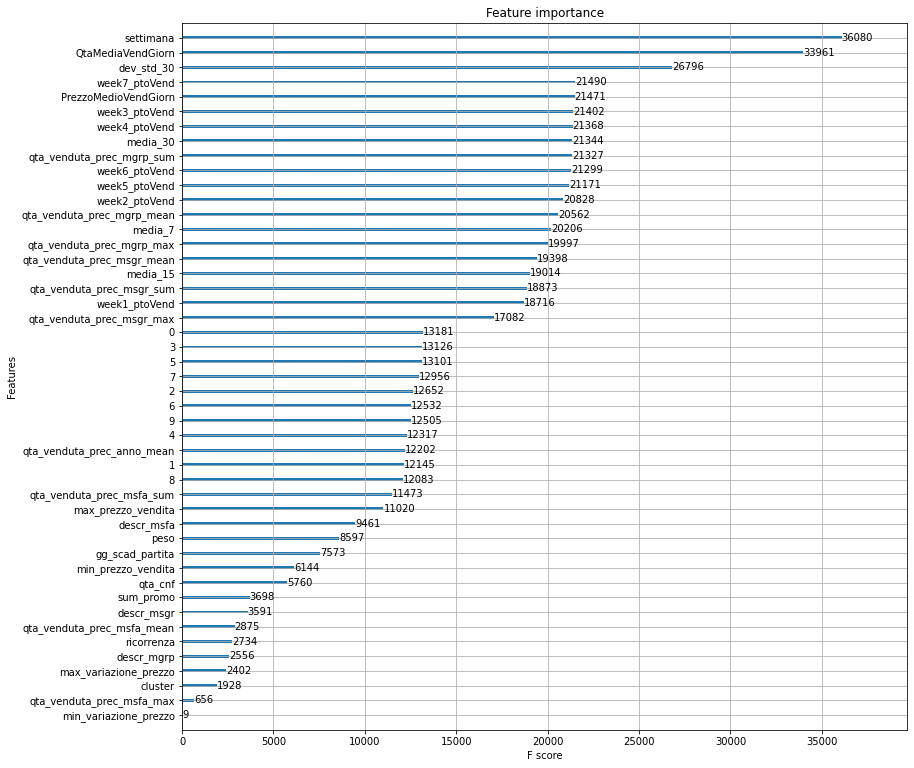

In [83]:
xgb.plot_importance(xg_reg2)
plt.rcParams['figure.figsize'] = [13, 13]
plt.show()

# Data Analysis

In [266]:
df_val['qta_predetta']=np.around(preds)
df_val['agent_sales']=df_val['qta_venduta']-df_val['inevaso']+df_val['QuantitaResa']+df_val['QuantitaSostituita']
#df_val['valore_predetto']=df_val['qta_predetta']*df_val.prezzo_vendita
#df_val['valore_ottimo']=df_val['qta_venduta']*df_val.prezzo_vendita
#df_val['valore_agente']=df_val['agent_sales']*df_val.prezzo_vendita

In [267]:
df=df_val[['cod_mart','settimana','qta_venduta','qta_predetta','agent_sales','qta_cnf','QtaMediaVendGiorn']]

In [268]:
df=df.groupby(['cod_mart','settimana']).sum().reset_index()

In [269]:
df[(df.cod_mart==sales_mapping_art['020535'])]

cod_mart  settimana  qta_venduta  qta_predetta  agent_sales  qta_cnf  \
747        47         39         15.0          21.0         15.0     12.0   
748        47         40        878.0         603.0        766.0     12.0   
749        47         41          6.0          37.0          0.0     12.0   

     QtaMediaVendGiorn  
747               15.0  
748              781.0  
749                0.0

In [258]:
def plotta_art(cod_mart):
    plt.plot(df[(df.cod_mart==cod_mart)].reset_index().qta_venduta, 'b') # plotting t, b separately 
    plt.plot( df[(df.cod_mart==cod_mart)].reset_index().qta_predetta, 'g') # plotting t, c separately 
    plt.plot( df[(df.cod_mart==cod_mart)].reset_index().QtaMediaVendGiorn, 'r') # plotting t, c separately 
    plt.rcParams['figure.figsize'] = [100, 10]
    plt.show()

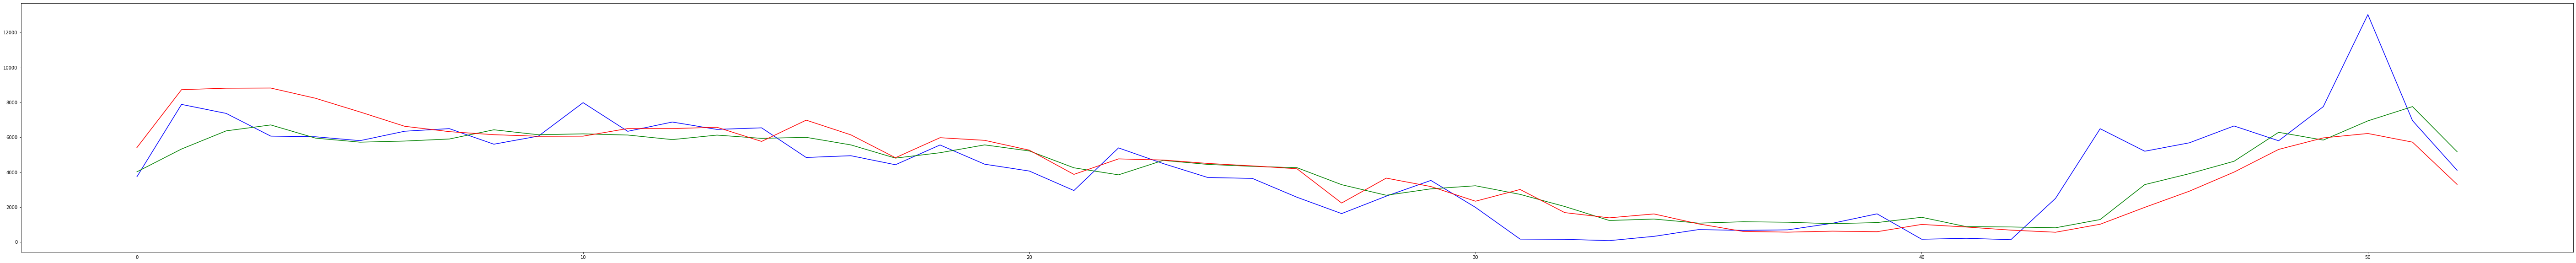

In [259]:
plotta_art(sales_mapping_art['841002'])

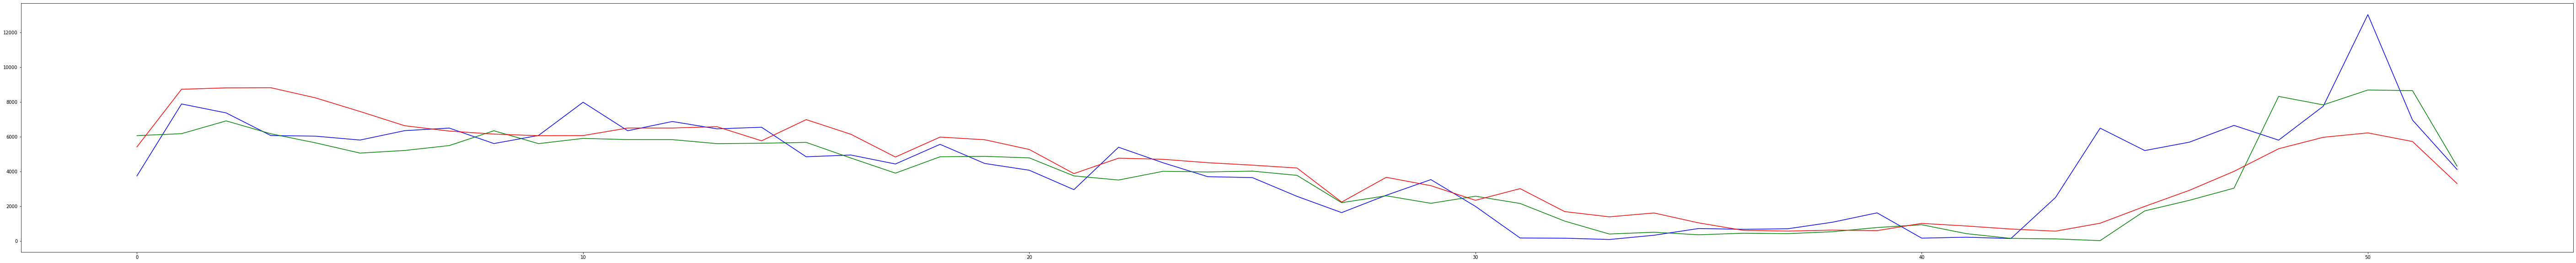

In [139]:
plotta_art(sales_mapping_art['841002'])

In [224]:
import warnings
from sklearn.metrics import *
codici=df_val.cod_mart.unique()
def evaluate(param,dataFrame,dizionario= sales_mapping_art.items(),tweedie=True):
    evaluation=pd.DataFrame(columns=['expV_score','vendite_medie','maxerr','mae','mse','msle','median_absolut','r2s','mpd','mgd','mtd'])
    if(tweedie):
        dataFrame=dataFrame[(dataFrame.agent_sales>0) &(dataFrame.qta_predetta>0)]
        

    inv_map = {v: k for k, v in dizionario}
    elementi= dataFrame[param].unique()
    for elemento in elementi:
        y_true=dataFrame[dataFrame[param]==elemento].agent_sales
        y_pred=dataFrame[dataFrame[param]==elemento].qta_predetta
        
        vendite_medie=y_true.mean()
        
        evs=explained_variance_score(y_true,y_pred)
    #Explained variance regression score function
        maxerr=max_error(y_true, y_pred)
    #max_error metric calculates the maximum residual error.
        mae=mean_absolute_error(y_true, y_pred)
    #Mean absolute error regression loss.
        mse=mean_squared_error(y_true, y_pred)
    #Mean squared error regression loss.
        msle=mean_squared_log_error(y_true, y_pred)
    #Mean squared logarithmic error regression loss.
        medae=median_absolute_error(y_true, y_pred)
    #Median absolute error regression loss.
       # mape=mean_absolute_percentage_error(y_true,y_pred)
    #Mean absolute percentage error regression loss.
        r2s=r2_score(y_true, y_pred,)
    #R^2 (coefficient of determination) regression score function.
        if tweedie:
            mpd=mean_poisson_deviance(y_true, y_pred)
        #Mean Poisson deviance regression loss.
            mgd=mean_gamma_deviance(y_true, y_pred)
        #Mean Gamma deviance regression loss.
            mtd=mean_tweedie_deviance(y_true, y_pred,power=1.7)
        #Mean Tweedie deviance regression loss.
        else:
            mpd=0
            mgd=0
            mtd=0
        evaluation.loc[inv_map[elemento]]=[evs,vendite_medie,maxerr,mae,mse,msle,medae,r2s,mpd,mgd,mtd]
        warnings.filterwarnings('ignore')
    return evaluation.reset_index().sort_values('vendite_medie',ascending=False)

In [233]:
a=evaluate('cod_mart',df_val[(df_val.cod_mdep==0)],sales_mapping_art.items(),tweedie=True)

In [219]:
a[:100]

index  expV_score  vendite_medie   maxerr          mae           mse  \
360   873201    0.585342    4360.962264   6550.0  1241.037736  3.310321e+06   
346   841002    0.696627    4263.811321   5642.0  1093.226415  2.287430e+06   
322   831001    0.612141    3699.679245   4337.0  1087.981132  1.987578e+06   
297   802125    1.000000    3450.000000   1448.0  1448.000000  2.096704e+06   
347   841003    0.737194    3310.490566   4649.0   824.754717  1.373728e+06   
175   138711    0.445239    2977.019231   3785.0   731.346154  9.741328e+05   
170   138611    0.058028    2627.680000   3308.0   635.180000  8.585571e+05   
13    010900    0.499876    2580.339623   3632.0   748.792453  1.058827e+06   
202   209110    1.000000    2549.000000   1375.0  1375.000000  1.890625e+06   
361   873202    0.425134    2472.415094   4655.0   939.150943  1.676823e+06   
296   802076    0.008099    2415.000000   1725.0  1718.000000  2.951573e+06   
171   138616    0.387374    2346.529412   2220.0   476.176471  4.589456e+05   
177   138719    0.345676    2310.576923   3719.0   634.461538  9.686160e+05   
176   138716    0.503593    2209.788462   2662.0   580.519231  6.419763e+05   
1158  TLP007    0.453309    2143.622642   3746.0   680.528302  8.938777e+05   
352   847307    0.576850    2109.307692   2526.0   834.653846  1.030466e+06   
339   833206    0.493218    2025.490566   4083.0   840.603774  1.449136e+06   
330   831009    0.269947    1623.415094   4218.0   841.698113  1.414194e+06   
852   ORT004    0.455039    1547.254902   1828.0   410.450980  3.167956e+05   
331   831011    0.475038    1523.584906   1418.0   494.150943  3.940577e+05   
100   036040   -0.009507    1484.080000   1465.0   361.700000  2.679223e+05   
857   ORT011    0.555975    1442.979592   1544.0   304.673469  1.807814e+05   
323   831002    0.235956    1351.686275   1799.0   483.666667  3.934637e+05   
340   834015    0.529311    1350.750000   1348.0   419.461538  2.608180e+05   
93    035864    0.064354    1308.420000    803.0   279.160000  1.240615e+05   
951   POL023    0.588899    1279.000000   1442.0   364.730769  2.438885e+05   
349   841020    0.667582    1276.490566   2030.0   401.132075  3.034855e+05   
82    035704    0.602614    1260.333333   1160.0   290.098039  1.548224e+05   
186   156000    0.721035    1248.961538   1662.0   386.884615  2.911182e+05   
877   ORT035    0.547727    1223.520000   1290.0   274.500000  1.561142e+05   
1159  TLP008    0.635079    1206.377358   1368.0   335.547170  2.039896e+05   
324   831003    0.275107    1150.962264   1810.0   416.113208  3.013562e+05   
172   138624    0.066010    1090.120000   1125.0   343.100000  1.791774e+05   
74    033839    0.305936    1083.372549   1432.0   302.098039  1.807690e+05   
953   POR001    0.508668    1064.321429   1322.0   326.714286  2.892104e+05   
179   138722   -0.170373    1035.100000   2027.0   417.940000  3.568685e+05   
183   138788    0.380359    1011.860000   1652.0   367.020000  2.326034e+05   
94    036004   -0.189161     974.540000   1192.0   294.780000  1.585757e+05   
345   841001    0.516472     970.442308   1428.0   296.846154  1.625760e+05   
332   831014    0.500656     950.591837    923.0   307.183673  1.406194e+05   
86    035724    0.539196     937.240000   1126.0   228.760000  9.811032e+04   
174   138708    0.334438     934.740000   1049.0   286.040000  1.444084e+05   
285   752142    0.540888     930.056604   1158.0   265.396226  1.316125e+05   
63    032440    0.408005     929.760000   1189.0   279.860000  1.443561e+05   
312   811851   -0.502534     912.692308   3182.0  1134.923077  2.288394e+06   
348   841009    0.575845     890.788462   1155.0   278.346154  1.278764e+05   
190   165506    0.680239     873.981132    914.0   197.132075  7.574238e+04   
267   700115   -0.306260     861.040000   1701.0   510.280000  4.644608e+05   
858   ORT012    0.621239     842.020000    799.0   183.740000  5.939698e+04   
531   DUL533    0.114097     834.440000   7216.0   769.76

In [234]:
a[:100]

index  expV_score  vendite_medie   maxerr          mae           mse  \
351   873201    0.593432    4360.962264   6557.0  1224.584906  3.695602e+06   
337   841002    0.609405    4263.811321   6526.0  1160.698113  3.159987e+06   
313   831001    0.614273    3699.679245   5224.0  1045.547170  2.397511e+06   
289   802125    1.000000    3450.000000   3289.0  3289.000000  1.081752e+07   
338   841003    0.590906    3310.490566   6175.0   928.830189  2.283408e+06   
171   138711    0.358174    2977.019231   3687.0   821.980769  1.165311e+06   
166   138611   -0.032301    2627.680000   3789.0   702.320000  9.869352e+05   
10    010900    0.539793    2580.339623   3443.0   717.452830  1.077010e+06   
198   209110    1.000000    2549.000000   2294.0  2294.000000  5.262436e+06   
352   873202    0.345350    2472.415094   5623.0   902.528302  2.002695e+06   
288   802076   -0.377391    2415.000000   3670.0  2024.500000  6.806270e+06   
173   138719    0.117523    2355.843137   3887.0   844.882353  1.329199e+06   
167   138616    0.199603    2346.529412   2583.0   583.392157  6.112535e+05   
172   138716    0.436203    2253.078431   2288.0   615.098039  7.088578e+05   
1107  TLP007    0.435675    2143.622642   2852.0   701.490566  1.042138e+06   
343   847307    0.515243    2109.307692   3804.0   735.038462  1.127247e+06   
330   833206    0.576721    2025.490566   5280.0   724.264151  1.438135e+06   
321   831009    0.445291    1623.415094   3780.0   693.452830  1.219256e+06   
816   ORT004    0.519355    1547.254902   1888.0   421.274510  3.452535e+05   
322   831011    0.675771    1523.584906   1596.0   370.811321  2.911041e+05   
97    036040   -0.202884    1484.080000   1450.0   421.140000  3.367071e+05   
821   ORT011    0.417148    1418.980000   1667.0   378.100000  3.092683e+05   
314   831002    0.626619    1351.686275   1576.0   364.117647  2.398508e+05   
331   834015    0.647392    1350.750000   1568.0   479.923077  3.965857e+05   
90    035864   -0.200670    1308.420000    968.0   317.560000  1.718249e+05   
909   POL023    0.546450    1279.000000   1752.0   361.480769  2.908095e+05   
340   841020    0.628213    1276.490566   2645.0   382.962264  3.781422e+05   
79    035704    0.378481    1260.333333   1863.0   356.588235  2.395053e+05   
182   156000    0.800301    1248.961538   1284.0   364.923077  2.235870e+05   
840   ORT035    0.574912    1223.520000   1259.0   279.980000  1.599503e+05   
1108  TLP008    0.660502    1206.377358   1482.0   300.509434  2.039126e+05   
315   831003    0.687869    1150.962264   1286.0   286.792453  1.474125e+05   
911   POR001    0.511040    1145.961538   1176.0   343.807692  2.288052e+05   
71    033839    0.291749    1105.000000   1248.0   318.740000  1.733949e+05   
168   138624   -0.104622    1090.120000   1767.0   338.080000  2.242235e+05   
175   138722   -0.127616    1047.140000   2132.0   423.160000  3.399649e+05   
179   138788    0.266743    1011.860000   1807.0   389.360000  2.786196e+05   
91    036004   -0.153738     974.540000   1129.0   295.560000  1.594651e+05   
336   841001    0.570231     970.442308   1427.0   280.865385  1.794183e+05   
170   138708    0.189839     953.204082   1337.0   310.551020  1.668514e+05   
323   831014    0.619161     950.591837   1006.0   249.571429  1.188550e+05   
83    035724    0.252380     937.240000   1514.0   287.940000  1.553459e+05   
279   752142    0.559929     930.056604   1357.0   240.264151  1.414140e+05   
60    032440    0.396123     929.760000   1006.0   287.680000  1.525688e+05   
339   841009    0.588533     890.788462   1029.0   268.769231  1.453957e+05   
186   165506    0.722381     873.981132   1014.0   213.792453  9.358719e+04   
262   700115    0.487684     861.040000   1450.0   273.720000  1.811550e+05   
822   ORT012    0.539103     842.020000    933.0   231.300000  9.533190e+04   
318   831006    0.571641     814.830189    914.0   264.490566  1.183991e+05   
317   831005    0.542429     805.900000    886.0   261.92

In [104]:
a[:100]

index  expV_score  vendite_medie   maxerr          mae           mse  \
361   873201    0.609680    4360.962264   6341.0  1149.113208  3.031038e+06   
347   841002    0.673890    4263.811321   6550.0  1105.679245  2.463616e+06   
323   831001    0.649233    3699.679245   3926.0  1027.471698  1.747231e+06   
298   802125    1.000000    3450.000000    555.0   555.000000  3.080250e+05   
348   841003    0.689065    3310.490566   5198.0   879.943396  1.625413e+06   
174   138711    0.358537    2977.019231   3594.0   792.288462  1.116200e+06   
169   138611    0.038519    2627.680000   3665.0   639.340000  8.836761e+05   
12    010900    0.543214    2580.339623   3363.0   707.773585  8.960496e+05   
202   209110    1.000000    2549.000000    909.0   909.000000  8.262810e+05   
362   873202    0.508340    2472.415094   4874.0   843.698113  1.425405e+06   
297   802076   -0.685481    2415.000000   2256.0  2239.500000  5.015632e+06   
170   138616    0.292978    2346.529412   2515.0   517.117647  5.014163e+05   
176   138719    0.284790    2310.576923   3591.0   715.980769  1.057321e+06   
175   138716    0.457562    2209.788462   2714.0   602.519231  7.033393e+05   
1158  TLP007    0.513954    2143.622642   3072.0   633.773585  7.958311e+05   
353   847307    0.653559    2109.307692   3140.0   610.096154  7.457862e+05   
340   833206    0.458216    2025.490566   5185.0   823.622642  1.568195e+06   
331   831009    0.352650    1623.415094   3623.0   751.169811  1.244477e+06   
853   ORT004    0.491017    1547.254902   1899.0   380.450980  2.861410e+05   
332   831011    0.615668    1523.584906   1239.0   431.207547  2.884473e+05   
99    036040   -0.038599    1484.080000   1409.0   399.260000  3.007360e+05   
858   ORT011    0.558052    1418.980000   1508.0   305.080000  1.852514e+05   
324   831002    0.561765    1351.686275   1442.0   383.921569  2.285880e+05   
341   834015    0.701348    1350.750000   1075.0   331.173077  1.671232e+05   
92    035864   -0.005322    1308.420000    919.0   293.460000  1.382544e+05   
952   POL023    0.599395    1279.000000   1507.0   336.673077  2.296673e+05   
350   841020    0.645737    1276.490566   2440.0   372.415094  3.134112e+05   
81    035704    0.573900    1260.333333   1424.0   293.313725  1.635450e+05   
185   156000    0.777143    1248.961538   1289.0   346.557692  2.124422e+05   
878   ORT035    0.672246    1223.520000   1060.0   236.100000  1.127459e+05   
1159  TLP008    0.664363    1206.377358   1384.0   298.716981  1.740470e+05   
325   831003    0.620809    1150.962264   1143.0   319.622642  1.575240e+05   
954   POR001    0.546667    1103.703704   1203.0   359.481481  2.308256e+05   
171   138624    0.234392    1090.120000   1118.0   287.920000  1.484231e+05   
73    033839    0.457408    1083.372549   1210.0   269.235294  1.307753e+05   
178   138722    0.041517    1026.647059   1927.0   387.156863  2.898723e+05   
182   138788    0.349711    1011.860000   1543.0   367.060000  2.457222e+05   
93    036004   -0.000224     974.540000   1165.0   251.520000  1.352642e+05   
346   841001    0.594498     970.442308   1271.0   265.903846  1.363171e+05   
333   831014    0.643375     950.591837    856.0   259.571429  1.002530e+05   
85    035724    0.508450     937.240000   1084.0   244.780000  1.035404e+05   
286   752142    0.591088     930.056604   1328.0   247.622642  1.239410e+05   
62    032440    0.395268     929.760000   1057.0   265.520000  1.304219e+05   
173   138708    0.368624     920.529412   1155.0   282.039216  1.399745e+05   
349   841009    0.618032     890.788462    949.0   271.769231  1.152902e+05   
190   165506    0.705768     873.981132    893.0   198.415094  6.973087e+04   
268   700115    0.642551     861.040000   1231.0   220.620000  1.142408e+05   
859   ORT012    0.611173     842.020000    844.0   185.840000  5.845360e+04   
313   811851   -0.217264     841.357143   3495.0   987.071429  1.907125e+06   
328   831006    0.531110     814.830189    905.0   261.92